# Predictor del número de muertes por COVID-19 usando un Regresor Lineal

## Librerias usadas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Obtenición y Análisis de los datos

Los datos utilizados para este proyecto fueron extraidos desde 'https://raw.githubusercontent.com/jmcastagnetto/covid-19-peru-data/master/datos/covid-19-peru-data.csv'. El repositorio que lo contiene provee de manera libre los datos oficiales recopilados desde las fuentes oficales del gobierno peruano.

In [2]:
url = 'https://raw.githubusercontent.com/jmcastagnetto/covid-19-peru-data/master/datos/covid-19-peru-data.csv'
full_data = pd.read_csv(url)
full_data.tail()

,country,iso3c,region,date,confirmed,deaths,recovered,negative_cases,pcr_positivo,prueba_rapida_positivo,pcr_prapida_positivo
1600,Peru,PER,San Martín,2020-05-22,2297,25.0,NaN,NaN,445.0,1852.0,NaN
1601,Peru,PER,Tacna,2020-05-22,119,NaN,NaN,NaN,11.0,108.0,NaN
1602,Peru,PER,Tumbes,2020-05-22,2557,196.0,NaN,NaN,515.0,2042.0,NaN
1603,Peru,PER,Ucayali,2020-05-22,399,18.0,NaN,NaN,96.0,303.0,NaN
1604,Peru,PER,NaN,2020-05-22,111698,3244.0,44848.0,638828.0,30823.0,80875.0,NaN


Hacemos una revisión general sobre los datos

In [166]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1605 entries, 0 to 1604
Data columns (total 11 columns):
country                   1605 non-null object
iso3c                     1605 non-null object
region                    1528 non-null object
date                      1605 non-null object
confirmed                 1605 non-null int64
deaths                    1014 non-null float64
recovered                 95 non-null float64
negative_cases            77 non-null float64
pcr_positivo              1115 non-null float64
prueba_rapida_positivo    1052 non-null float64
pcr_prapida_positivo      24 non-null float64
dtypes: float64(6), int64(1), object(4)
memory usage: 138.0+ KB


In [167]:
full_data.describe()

,confirmed,deaths,recovered,negative_cases,pcr_positivo,prueba_rapida_positivo,pcr_prapida_positivo
count,1605.000000,1014.000000,95.000000,77.000000,1115.000000,1052.000000,24.000000
mean,2536.690343,111.332347,7148.136842,176580.259740,1243.748879,2402.262357,34.583333
std,10804.204509,346.535040,11031.539305,202595.412091,4160.414361,8931.397281,72.926358
min,1.000000,1.000000,1.000000,154.000000,1.000000,1.000000,1.000000
25%,19.000000,2.000000,8.000000,8639.000000,17.000000,67.000000,1.750000
50%,149.000000,7.000000,989.000000,91913.000000,76.000000,189.000000,3.000000
75%,598.000000,62.000000,9608.000000,329168.000000,304.500000,691.000000,6.250000
max,111698.000000,3244.000000,44848.000000,638828.000000,30823.000000,80875.000000,231.000000


Dos columnas interesantes son: `confirmed` y `deaths`, porque son columnas con pocos datos faltantes y mantienen una relación lineal. Por eso se decidió usar estas dos columnas junto con `date`.

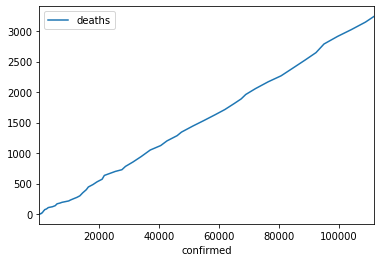

In [170]:
full_data[pd.isnull(full_data['region'])].plot(x='confirmed',y='deaths')

Separamos los registros que necesitamos, en este caso serán los que estan `NaN` en la columna `region`. Estas filas contienen las cifras de todo el pais.

Luego separamos las columnas con las que trabajaremos.
- Fecha - `date`
- Número de casos confirmados - `confirmed`
- Núemro de muertes - `deaths`

In [80]:
data_peru = full_data.loc[pd.isnull(full_data['region'])]
data_peru = data_peru.drop(['country','iso3c','region','recovered','negative_cases','pcr_positivo','prueba_rapida_positivo','pcr_prapida_positivo'],
                     axis=1)

Creamos primero dos subconjuntos, ambos tendrán como variable independiente la fecha, o cantidad de dias transcurridos, y la variable dependiente será `confirmed` y `deaths` respectivamente.

In [81]:
date_deaths = data_peru[['date','deaths','confirmed']]
date_confirmed = data_peru[['date','confirmed','deaths']]
date_deaths = date_deaths.drop(['confirmed'],axis=1)
date_confirmed = date_confirmed.drop(['deaths'],axis=1)

Para trabajar con la fecha, primero la convertimos a valor numérico, esto nos permitirá ubicar las fechas. En este trabajo se opto por utilizar los datos antes de mayo para entrenar, y los datos porteriores como prueba, es por eso que guardamos en `mayo_1` el indice que nos servirá para separar

In [82]:
date_deaths['date'] = pd.to_datetime(date_deaths['date']).dt.strftime("%Y%m%d").astype(int)
date_confirmed['date'] = pd.to_datetime(date_confirmed['date']).dt.strftime("%Y%m%d").astype(int)

new_date = list(range(1,len(date_confirmed)+1))

raw_DD = date_deaths.values
mayo_1 = np.where(raw_DD[:,0]==20200501)

Generamos también un arreglo continuo de enteros `new_date` que representará los días transcurridos, este arreglo reemplazará la columna `date`

In [7]:
raw_DD = date_deaths.values.astype(np.float32)
raw_DD[:,0] = new_date
raw_DC = date_confirmed.values.astype(np.float32)
raw_DC[:,0] = new_date

## Adaptación de los Datos

Como en algunos registros el valor de `death` es `NaN` lo convertimos en 0. En este caso, los valores `Nan` significan que en esos días no hubieron muertos, por eso lo cambiamos por 0.

In [8]:
ind = np.where(np.isnan(raw_DD))
raw_DD[ind] = 0

In [11]:
def Normalizar_Datos( arraynp ):
    mean = np.nanmean(arraynp,0)
    standard = np.nanstd(arraynp,0)
    print (mean, standard)
    for i in range(0,arraynp.shape[0]):
        arraynp[i] = np.true_divide((arraynp[i] - mean), standard)
    return arraynp, mean, standard

Normalizamos los datos con la función `Normalizar_Datos` que nos retorna el arreglo normalizado, la media y la desviación estardar que se utilizaron para la normalización.

In [12]:
raw_DD, _, _ = Normalizar_Datos(raw_DD)
raw_DC, _, _ = Normalizar_Datos(raw_DC)

[ 39.     744.4415] [ 22.22611 952.23883]
[   39.    26438.014] [2.2226110e+01 3.3089445e+04]


In [13]:
def Adapt_sets(train_set, test_set):
    test_y = test_set[:,-1:]
    test_x = test_set[:,0:-1]
    train_y = train_set[:,-1:]
    train_x = train_set[:,0:-1]
    
    train_x = np.insert(train_x, 0, 1, axis=1)
    test_x = np.insert(test_x, 0, 1, axis=1)
    
    return train_x, train_y, test_x, test_y

Separamos los conjuntos de datos, en entrenamiento (`x` e `y`) y prueba (`x` e `y`), para esto nos apoyamos de la función `Adapt_sets`

Tambien creamos los vetores de los $\theta$

In [14]:
train_set_DD, test_set_DD = np.split(raw_DD,mayo_1[0])
train_set_DC, test_set_DC = np.split(raw_DC,mayo_1[0])

train_DD_x, train_DD_y, test_DD_x, test_DD_y = Adapt_sets(train_set_DD, test_set_DD)
Theta_DD = np.zeros(train_DD_x.shape[1])[np.newaxis]

train_DC_x, train_DC_y, test_DC_x, test_DC_y = Adapt_sets(train_set_DC, test_set_DC)
Theta_DC = np.zeros(train_DC_x.shape[1])[np.newaxis]

In [15]:
def Calcular_Costo(X, Y, Theta):
    m = len(X)
    cost = np.sum((X.dot(Theta.T) - Y)**2) / (2 * m)
    return cost

def Gradiente_Descendiente(X, Y, Theta, iteraciones, tasa):
    costos = [0]*iteraciones
    m = len(X)
    for itr in range(iteraciones):
        h = X.dot(Theta.T)
        dif = h - Y
        derivada = (X.T).dot(dif) / m
        Theta = Theta - (tasa * derivada).T
        costos[itr] = Calcular_Costo(X, Y, Theta)
    return Theta, costos

Aplicamos el algoritmo de Gradiente Descendiente para realizar la regresión lineal. Luego calculamos los valores para el conjunto de prueba usando los nuevos $\theta$

In [16]:
newTheta_DD, costos_DD = Gradiente_Descendiente(train_DD_x, train_DD_y, Theta_DD, 2500, 0.1)
newTheta_DC, costos_DC = Gradiente_Descendiente(train_DC_x, train_DC_y, Theta_DC, 2500, 0.1)

In [17]:
DD_y_predict = test_DD_x.dot(newTheta_DD.T)
DC_y_predict = test_DC_x.dot(newTheta_DC.T)

Text(0.5, 0, 'Dias')

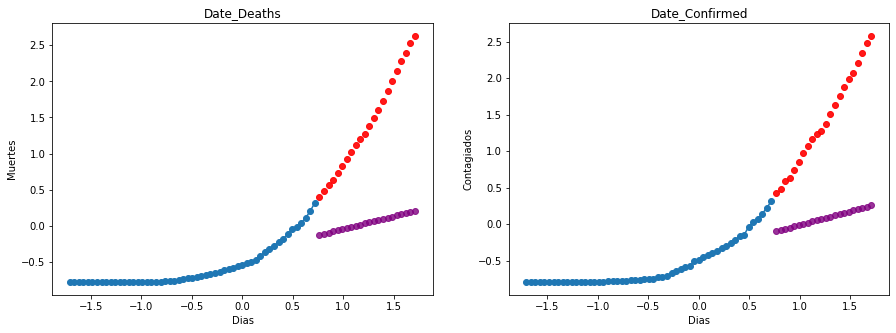

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].scatter(test_DD_x[:,1], test_DD_y, alpha=0.9, c="red")
ax[0].scatter(test_DD_x[:,1], DD_y_predict, alpha=0.8, c="purple")
ax[0].plot(train_DD_x[:,1], train_DD_y, "-o")
ax[0].set_title("Date_Deaths")
ax[0].set_ylabel('Muertes')
ax[0].set_xlabel('Dias')

ax[1].scatter(test_DC_x[:,1], test_DC_y, alpha=0.9, c="red")
ax[1].scatter(test_DC_x[:,1], DC_y_predict, alpha=0.8, c="purple")
ax[1].plot(train_DC_x[:,1], train_DC_y, "-o")
ax[1].set_title("Date_Confirmed")
ax[1].set_ylabel('Contagiados')
ax[1].set_xlabel('Dias')

Graficamos lo resultados obtenidos y nos damos cuenta que el modelo no es nada útil ya que el conportamiento de cualquiera de las variables, `deaths` y `confirmed`, no es lineal, sino similar a exponencial

Entonces creamos un nuevo subconjunto de datos con `date` y `confirmed` como variables independientes, y `deaths` como la variable dependiente.

In [19]:
date_confirmed_deaths = data_peru[['date','confirmed','deaths']]

In [20]:
date_confirmed_deaths['date'] = pd.to_datetime(date_confirmed_deaths['date']).dt.strftime("%Y%m%d").astype(int)
date_confirmed_deaths.head()

,date,confirmed,deaths
0,20200306,1,NaN
1,20200307,6,NaN
2,20200309,9,NaN
3,20200310,11,NaN
4,20200311,17,NaN


Para trabajar con ambas variables podemos utilizar dos enfoques, usar simplemente la cantidad total de los casos confirmados hasta un día, o usar la cantidad de casos nuevos por día.

## Casos nuevos por día

Para calcular esto simplemente recorremos el conjunto original y restamos los casos de un día con los del anterior. También calculamos la tasa de crecimiento de casos confirmados que nos permitira estimar la cantidad de casos de contagio en dias posteriores, esto se calcula dividiendo el número de casos de un día con los del anterior, y los promediamos. Como el comportamiento es similar a exponencial, consideramos solo las últimas 10 variaciones para obtener la tasa de crecimiento.

In [28]:
data_raw_DCD = date_confirmed_deaths.values.astype(np.float32)
ind = np.where(np.isnan(data_raw_DCD))
data_raw_DCD[ind] = 0

Oraw_DCD = np.zeros(data_raw_DCD.shape)
crecimiento = np.zeros(len(data_raw_DCD) - 1)
Oraw_DCD[0] = data_raw_DCD[0]
Oraw_DCD[:,0] = new_date[:]

for i in range(1,len(data_raw_DCD)):
    Oraw_DCD[i,1] = data_raw_DCD[i,1] - data_raw_DCD[i-1,1]
    Oraw_DCD[i,2] = data_raw_DCD[i,2] - data_raw_DCD[i-1,2]
    crecimiento[i-1] = data_raw_DCD[i,1] / data_raw_DCD[i-1,1]

av_crecimiento = np.mean(crecimiento[-10:])
av_crecimiento

1.0448516368865968

Text(0.5, 0, 'Dias')

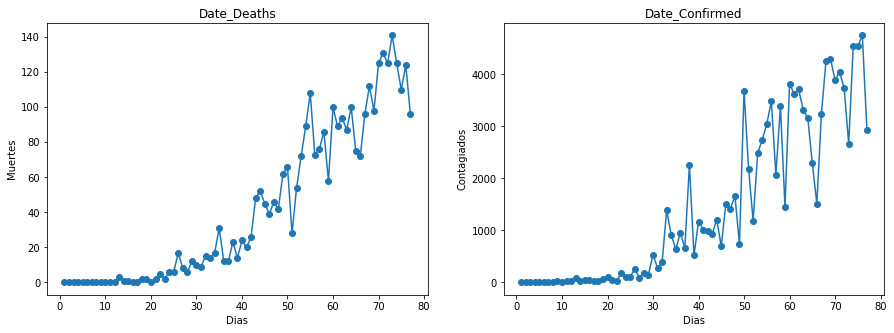

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(Oraw_DCD[:,0], Oraw_DCD[:,2], "-o")
ax[0].set_title("Date_Deaths")
ax[0].set_ylabel('Muertes')
ax[0].set_xlabel('Dias')

ax[1].plot(Oraw_DCD[:,0], Oraw_DCD[:,1], "-o")
ax[1].set_title("Date_Confirmed")
ax[1].set_ylabel('Contagiados')
ax[1].set_xlabel('Dias')

In [30]:
Oraw_DCD, _, _ = Normalizar_Datos(Oraw_DCD)
train_set_DCD, test_set_DCD = np.split(Oraw_DCD,mayo_1[0])

train_DCD_x, train_DCD_y, test_DCD_x, test_DCD_y = Adapt_sets(train_set_DCD, test_set_DCD)
Theta_DCD = np.zeros(train_DCD_x.shape[1])[np.newaxis]

[  39.         1450.62337662   42.12987013] [  22.22611077 1517.15524156   43.63078582]


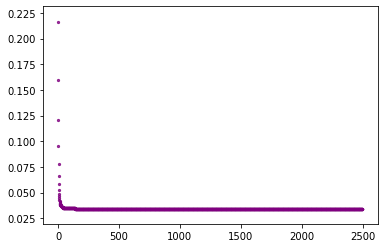

In [31]:
newTheta_DCD, costos_DCD = Gradiente_Descendiente(train_DCD_x, train_DCD_y, Theta_DCD, 2500, 0.1)
plt.scatter(np.arange(2500), costos_DCD, alpha=0.8, c="purple", s=5)

Text(0, 0.5, 'Nuevas Muertes')

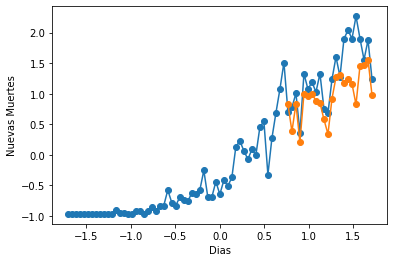

In [32]:
DCD_y_test = test_DCD_x.dot(newTheta_DCD.T)

plt.plot(Oraw_DCD[:,0], Oraw_DCD[:,-1],'-o')
plt.plot(test_DCD_x[:,1], DCD_y_test,'-o')
plt.xlabel('Dias')
plt.ylabel('Nuevas Muertes')

Calculamos los casos nuevos de muertes por día y lo evaluamos con las metricas estandar r2, mean squared error y root mean squared error.

In [36]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

In [37]:
print ('r2 score', r2_score(test_DCD_y, DCD_y_test))
print ('MSE', mean_squared_error(test_DCD_y, DCD_y_test))
print ('RMSE', sqrt(mean_squared_error(test_DCD_y, DCD_y_test)))

r2 score 0.05892219673437182
MSE 0.23303861800751144
RMSE 0.48274073580702864


Los resultados obtenido bajo este enfoque no son buenos

## Total de casos

** La variable futuro representa la cantidad de días futuros a los que se predicirá una cantidad de muertes, en este caso se hará una predicción a los proximos 30 días.

In [83]:
data_raw_DCD = date_confirmed_deaths.values.astype(np.float32)
ind = np.where(np.isnan(data_raw_DCD))
data_raw_DCD[ind] = 0
data_raw_DCD[:,0] = new_date

futuro = 30
cnt_real = len(data_raw_DCD)

Operamos de manera similar que con los primeros conjuntos de datos

In [84]:
raw_DCD, _, _ = Normalizar_Datos(data_raw_DCD)

train_set_DCD, test_set_DCD = np.split(raw_DCD,mayo_1[0])

train_DCD_x, train_DCD_y, test_DCD_x, test_DCD_y = Adapt_sets(train_set_DCD, test_set_DCD)
Theta_DCD = np.zeros(train_DCD_x.shape[1])[np.newaxis]

[   39.     26438.014    744.4415] [2.2226110e+01 3.3089445e+04 9.5223883e+02]


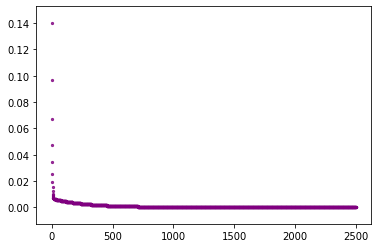

In [85]:
newTheta_DCD, costos_DCD = Gradiente_Descendiente(train_DCD_x, train_DCD_y, Theta_DCD, 2500, 0.1)
plt.scatter(np.arange(2500), costos_DCD, alpha=0.8, c="purple", s=5)

Text(0.5, 0, 'Dias')

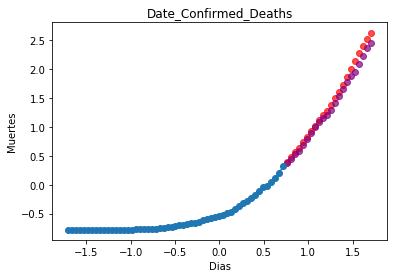

In [87]:
DCD_y_test = test_DCD_x.dot(newTheta_DCD.T)

plt.scatter(test_DCD_x[:,1], test_DCD_y, alpha=0.7, c="red")
plt.scatter(test_DCD_x[:,1], DCD_y_test, alpha=0.7, c="purple")
plt.plot(train_DCD_x[:,1], train_DCD_y, "-o")
plt.title("Date_Confirmed_Deaths")
plt.ylabel('Muertes')
plt.xlabel('Dias')

In [88]:
print ('r2 score', r2_score(test_DCD_y, DCD_y_test))
print ('MSE', mean_squared_error(test_DCD_y, DCD_y_test))
print ('RMSE', sqrt(mean_squared_error(test_DCD_y, DCD_y_test)))

r2 score 0.9781488779020928
MSE 0.010147105616042451
RMSE 0.10073284278745662


Los resultados obtenidos tras evaluar el modelo en el conjunto de prueba nos muestran que es mucho mejor utilizar este enfoque.

## Predicción 

Primero generamos la nueva relación de días, hasta los que queremos predecir

In [89]:
new_date = np.arange(cnt_real + futuro)
new_date+=1

raw_DCD_P = np.empty((cnt_real + futuro,data_raw_DCD.shape[1]))
raw_DCD_P[:,0] = new_date

- Reiniciamos el conjunto de datos originales
- Estimamos la cantidad de contagiados para los próximos días, usando la tasa de crecimiento
- unimos la data real con la sintetica en `raw_DCD_P`

In [92]:
data_raw_DCD = date_confirmed_deaths.values.astype(np.float32)
ind = np.where(np.isnan(data_raw_DCD))
data_raw_DCD[ind] = 0

future_confirmed = np.empty((futuro,1))
future_deaths = np.empty((futuro,1))
future_deaths[:] = np.nan

future_confirmed[0] = data_raw_DCD[-1,1] * av_crecimiento
for i in range(1, futuro):
    future_confirmed[i] = future_confirmed[i-1] * av_crecimiento

raw_DCD_P[:,0] = new_date
raw_DCD_P[:cnt_real,1] = data_raw_DCD[:,1]
raw_DCD_P[:cnt_real,2] = data_raw_DCD[:,2]
raw_DCD_P[cnt_real:,1] = future_confirmed.T
raw_DCD_P[cnt_real:,2] = future_deaths.T

Realizamos la divición en 3 conjuntos: entrenamiento, prueba, y predicción
Los acuamos para que se puedan usar

In [93]:
raw_DCD_P, mean_DCD, std_DCD = Normalizar_Datos(raw_DCD_P)
ptr = np.append (mayo_1[0],[cnt_real])
train_set_DCD_P, test_set_DCD_P, pred_set_DCD = np.split(raw_DCD_P, ptr)
print(train_set_DCD_P.shape, test_set_DCD_P.shape, pred_set_DCD.shape)

train_DCDP_x, train_DCDP_y, test_DCDP_x, test_DCDP_y = Adapt_sets(train_set_DCD_P, test_set_DCD_P)
# Theta_DCD = np.zeros(train_DCD_x.shape[1])[np.newaxis]

pred_DCD_x = pred_set_DCD[:,0:-1]
pred_DCD_x = np.insert(pred_DCD_x, 0, 1, axis=1)

[5.40000000e+01 8.54005480e+04 7.44441558e+02] [3.08868904e+01 1.09151277e+05 9.52238804e+02]
(55, 3) (22, 3) (30, 3)


Realizamos la predicción sobre el conjunto de pruebas de los datos sintéticos
Para poder mostrarlo graficamente reescalamos los datos

- Para una buena visualización, los resultados de predicción son movidos


No se reescalan los dias transcurridos porque ya conocemos que dias son

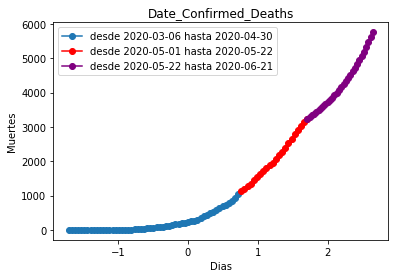

In [95]:
DCD_y_pred = pred_DCD_x.dot(newTheta_DCD.T)

dif_x = test_DCD_x[-1,1] - pred_DCD_x[0,1]
dif_y = test_DCD_y[-1] - DCD_y_pred[0]

pred_DCD_x[:,1] += dif_x
DCD_y_pred += dif_y

plt.plot(train_DCD_x[:,1], train_DCD_y*std_DCD[2]+mean_DCD[2], "-o",label='desde 2020-03-06 hasta 2020-04-30')
plt.plot(test_DCD_x[:,1], test_DCD_y*std_DCD[2]+mean_DCD[2],"-o",color="red",label='desde 2020-05-01 hasta 2020-05-22')
plt.plot(pred_DCD_x[:,1], DCD_y_pred*std_DCD[2]+mean_DCD[2], "-o",color="purple",label='desde 2020-05-22 hasta 2020-06-21')

plt.title("Date_Confirmed_Deaths")
plt.ylabel('Muertes')
plt.xlabel('Dias')
plt.legend()

Ahora solo mostramos las predicciones para los siguientes 30 dias

In [97]:
real_pred = np.rint(DCD_y_pred*std_DCD[2]+mean_DCD[2])
real_pred.T

array([[3244., 3288., 3333., 3381., 3431., 3483., 3538., 3595., 3655.,
        3717., 3782., 3850., 3921., 3995., 4073., 4154., 4239., 4327.,
        4420., 4516., 4617., 4723., 4833., 4949., 5069., 5195., 5326.,
        5464., 5608., 5758.]])

## Predicción a Arequipa

Para obtener un modelo exclusivo de Arequipa, primero seleccionamos las filas que en region sea "Arequipa". Estas filas tienen las cifras de la region Areuipa desde 2020-03-13

In [111]:
data_aqp = full_data.loc[full_data['region'] == 'Arequipa']
data_aqp = data_aqp.drop(['country','iso3c','region','recovered','negative_cases','pcr_positivo','prueba_rapida_positivo','pcr_prapida_positivo'],
                     axis=1)
data_aqp.tail(20)

,date,confirmed,deaths
1088,2020-05-03,692,16.0
1114,2020-05-04,692,NaN
1140,2020-05-05,763,18.0
1166,2020-05-06,790,20.0
1192,2020-05-07,814,20.0
1218,2020-05-08,854,20.0
1244,2020-05-09,904,20.0
1270,2020-05-10,1046,20.0
1296,2020-05-11,1061,20.0
1322,2020-05-12,1208,20.0


Los datos de Arequipa son un poco diferentes en algunos registros. Por ello realizamos las siguientes modificaciones:
* Notamos que el dia 2020-05-04 no se registro fallecidos, siendo imposible que este valor sea 0, tenemos que cambiar la forma de darle valores a NaN. el Primer `NaN` seguramente es 0, y los posteriores `NaN` seran iguales al valor inmediato anterior.
* Notamos que en el ultimo registro los valores son considerablemente menores, siendo que el número de muertes no puede disminuir debemos asumir que se reguistro el número de nuevos casos y no los casos totales. Por ello al ultimo reguistro lo modificamos, como la suma de este con el anterior

In [155]:
data_aqp['date'] = pd.to_datetime(data_aqp['date']).dt.strftime("%Y%m%d").astype(int)
raw_AQP = data_aqp.values
# mayo_1_aqp = np.where(raw_AQP[:,0]==20200501)

new_date_AQP = list(range(len(raw_AQP)))
raw_AQP[:,0] = new_date_AQP

raw_AQP[0,2] = 0
for i in range(1,len(raw_AQP)):
    if(np.isnan(raw_AQP[i,2])):
        raw_AQP[i,2] = raw_AQP[i-1,2]

        
raw_AQP = raw_AQP.astype(np.float32)
raw_AQP[-1,1] = raw_AQP[-2,1] + raw_AQP[-1,1]
raw_AQP[-1,2] = raw_AQP[-2,2] + raw_AQP[-1,2]

Text(0, 0.5, 'Dias')

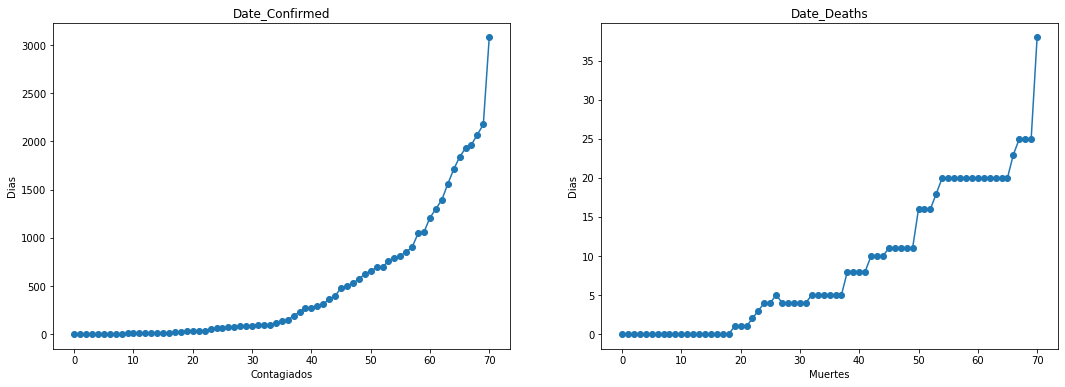

In [156]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))

ax[0].plot(raw_AQP[:,0], raw_AQP[:,1], "-o")
ax[0].set_title("Date_Confirmed")
ax[0].set_xlabel('Contagiados')
ax[0].set_ylabel('Dias')

ax[1].plot(raw_AQP[:,0], raw_AQP[:,2], "-o")
ax[1].set_title("Date_Deaths")
ax[1].set_xlabel('Muertes')
ax[1].set_ylabel('Dias')

Luego solo debemos proceder de la misma manera que con los previos conjuntos de datos

In [157]:
raw_AQP, mean_AQP, std_AQP = Normalizar_Datos(raw_AQP)
train_set_AQP, test_set_AQP = np.split(raw_AQP,mayo_1_aqp[0])
print(train_set_AQP.shape, test_set_AQP.shape)
train_AQP_x, train_AQP_y, test_AQP_x, test_AQP_y = Adapt_sets(train_set_AQP, test_set_AQP)
Theta_AQP = np.zeros(train_AQP_x.shape[1])[np.newaxis]

[ 35.        494.39438     8.8732395] [ 20.493902 670.3579     8.892043]
(49, 3) (22, 3)


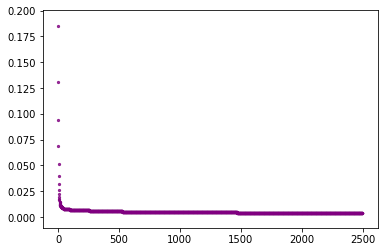

In [158]:
newTheta_AQP, costos_AQP = Gradiente_Descendiente(train_AQP_x, train_AQP_y, Theta_AQP, 2500, 0.1)
plt.scatter(np.arange(2500), costos_AQP, alpha=0.8, c="purple", s=5)

Text(0, 0.5, 'Nuevas Muertes')

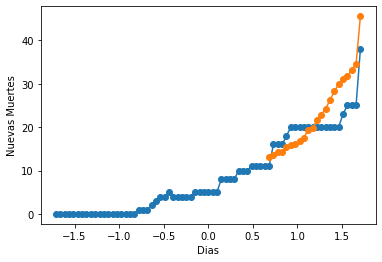

In [159]:
AQP_y_test = test_AQP_x.dot(newTheta_AQP.T)

plt.plot(raw_AQP[:,0], raw_AQP[:,-1]*std_AQP[2]+mean_AQP[2],'-o')
plt.plot(test_AQP_x[:,1], AQP_y_test*std_AQP[2]+mean_AQP[2],'-o')
plt.xlabel('Dias')
plt.ylabel('Nuevas Muertes')

Luego de evaluar los resultados con las mismas métricas vemos que el modelo no es bueno.

Viendo la grafica anterior, notamos que los datos no son muy del todo continuos y presentan irregularidades.

In [160]:
print ('r2 score', r2_score(test_AQP_y, AQP_y_test))
print ('MSE', mean_squared_error(test_AQP_y, AQP_y_test))
print ('RMSE', sqrt(mean_squared_error(test_AQP_y, AQP_y_test)))

r2 score -0.18452374336792543
MSE 0.3631653369131425
RMSE 0.6026320078730821


Luego de obtener el modelo de predicción para arequipa, hacemos lo mismo que para predecir en Perú. Calcular los datos sintéticos para los próximos 20 días. Se opto por menos datos ya que el modelo no es muy bueno.

In [161]:
raw_AQP = data_aqp.values.astype(np.float32)
futuro_AQP = 20
cnt_real_AQP = len(raw_AQP)

new_date_AQP = np.arange(cnt_real_AQP + futuro_AQP)
new_date_AQP+=1

raw_AQP_P = np.empty((cnt_real_AQP + futuro_AQP, raw_AQP.shape[1]))
raw_AQP_P[:,0] = new_date_AQP
raw_AQP = raw_AQP.astype(np.float32)
raw_AQP[-1,1] = raw_AQP[-2,1] + raw_AQP[-1,1]
raw_AQP[-1,2] = raw_AQP[-2,2] + raw_AQP[-1,2]

In [162]:
crecimiento_AQP = np.empty(len(raw_AQP)-1)
for i in range(1,len(raw_AQP)):
    crecimiento_AQP[i-1] = raw_AQP[i,1] / raw_AQP[i-1,1]
av_crecimiento_AQP = np.mean(crecimiento_AQP[-10:])
av_crecimiento_AQP

1.1026332378387451

In [163]:
raw_AQP[0,2] = 0
for i in range(1,len(raw_AQP)):
    if(np.isnan(raw_AQP[i,2])):
        raw_AQP[i,2] = raw_AQP[i-1,2]

AQP_future_confirmed = np.empty((futuro_AQP,1))
AQP_future_deaths = np.empty((futuro_AQP,1))
AQP_future_deaths[:] = np.nan

AQP_future_confirmed[0] = raw_AQP[-1,1] * av_crecimiento_AQP
for i in range(1, futuro_AQP):
    AQP_future_confirmed[i] = AQP_future_confirmed[i-1] * av_crecimiento_AQP

print (raw_AQP_P.shape)

raw_AQP_P[:,0] = new_date_AQP
raw_AQP_P[:cnt_real_AQP,1] = raw_AQP[:,1]
raw_AQP_P[:cnt_real_AQP,2] = raw_AQP[:,2]
raw_AQP_P[cnt_real_AQP:,1] = AQP_future_confirmed.T
raw_AQP_P[cnt_real_AQP:,2] = AQP_future_deaths.T

(91, 3)


In [164]:
raw_AQP_P, mean_AQP, std_AQP = Normalizar_Datos(raw_AQP_P)
ptr = np.append (mayo_1[0],[cnt_real_AQP])
train_set_AQP_P, test_set_AQP_P, pred_set_AQP = np.split(raw_AQP_P, ptr)
print(train_set_AQP_P.shape, test_set_AQP_P.shape, pred_set_AQP.shape)

train_AQP_x, train_AQP_y, test_AQP_x, test_AQP_y = Adapt_sets(train_set_AQP_P, test_set_AQP_P)
# Theta_DCD = np.zeros(train_DCD_x.shape[1])[np.newaxis]

pred_AQP_x = pred_set_AQP[:,0:-1]
pred_AQP_x = np.insert(pred_AQP_x, 0, 1, axis=1)

[  46.         2587.49962806    8.87323944] [  26.26785107 4742.30247977    8.89204357]
(55, 3) (16, 3) (20, 3)


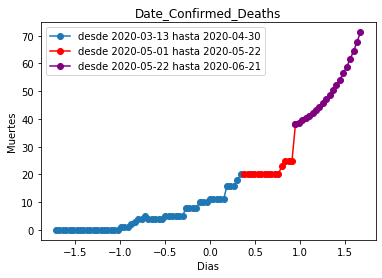

In [165]:
AQP_y_pred = pred_AQP_x.dot(newTheta_AQP.T)

dif_x = test_AQP_x[-1,1] - pred_AQP_x[0,1]
dif_y = test_AQP_y[-1] - AQP_y_pred[0]

pred_AQP_x[:,1] += dif_x
AQP_y_pred += dif_y

plt.plot(train_AQP_x[:,1], train_AQP_y*std_AQP[2]+mean_AQP[2], "-o",label='desde 2020-03-13 hasta 2020-04-30')
plt.plot(test_AQP_x[:,1], test_AQP_y*std_AQP[2]+mean_AQP[2],"-o",color="red",label='desde 2020-05-01 hasta 2020-05-22')
plt.plot(pred_AQP_x[:,1], AQP_y_pred*std_AQP[2]+mean_AQP[2], "-o",color="purple",label='desde 2020-05-22 hasta 2020-06-21')

plt.title("Date_Confirmed_Deaths")
plt.ylabel('Muertes')
plt.xlabel('Dias')
plt.legend()

A continuación se muestra las predicciones obtenidas para los próximos 20 días. En la gráfica anterior se muestran los resultados y vemos que muy posiblemente el modelo falle considerablemente

In [152]:
real_pred_AQP = np.rint(AQP_y_pred*std_AQP[2]+mean_AQP[2])
real_pred_AQP.T

array([[38., 39., 39., 40., 41., 42., 43., 44., 46., 47., 49., 50., 52.,
        54., 56., 59., 62., 64., 68., 71.]])